# American Time Use Survey

[Data and documentation](https://www.bls.gov/tus/data.htm)

In [1]:
import pandas as pd
import numpy as np
np.random.seed(91)

import requests
import io
import matplotlib.pyplot as plt
from dateutil.parser import parse
import datetime as dt
from zipfile import ZipFile
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
files = ['sum','resp'] # ["resp", "rost", "sum", "act", "cps", "who"]

ATUS = dict()

# multiyear data
# Zip files have URLs like https://www.bls.gov/tus/datafiles/atusrost-0322.zip
# Above pattern can change year to year. Update accordingly.

base_url = 'https://www.bls.gov/tus/datafiles/atus'
ending = f'-03{(dt.date.today() - dt.timedelta(days = 365)).strftime("%y")}.zip'


# Download data, read to pandas, and delete local files
for file in files:
    url = f'{base_url}{file}{ending}'
    r = requests.get(url)
    
    # Try to get data directly from web 
    try:
        # this doesn't work Aug '23 because BLS blocks bots
        z = ZipFile(io.BytesIO(r.content))
        z.extractall()
        ATUS[file] = pd.read_csv(z.open(ending))
    
    # Download files locally then delete
    except:
        print(url, 'click to download')
        input('Confirm Download')
        
        os.system(f'cp ~/Downloads/atus{file}{ending} {os.getcwd()}')
        with ZipFile(f'atus{file}{ending}', 'r') as z:
            z.extractall()
            dat = ending.replace(".zip",'.dat').replace("-",'_')
            ATUS[file] = pd.read_csv(z.open(f'atus{file}{dat}'))
            
            # delete files
            files = !ls
            for f in files:
                if f.startswith(f'atus{file}') or f.endswith("_info.txt"):
                    os.system(f"rm {f}")

https://www.bls.gov/tus/datafiles/atussum-0322.zip click to download
Confirm Download1
https://www.bls.gov/tus/datafiles/atusresp-0322.zip click to download
Confirm Download1


In [3]:
small = ATUS['sum'].sample(n = 500)
resp_df = ATUS['resp']
cols = [x for x in resp_df.columns if x not in list(small)] + ['TUCASEID']
resp_df = resp_df[cols]
small = small.merge(resp_df, on = 'TUCASEID', how = 'left', validate = 'one_to_one')

# Weekly earnings at main job (2 implied decimals)
earnings = small.TRERNWA / 100 

# Edited: how many hours per week do you usually work at your main
hours_working = small.TEHRUSL1

good = (earnings > 0) & (hours_working > 0)

ft = hours_working >= 35
pt = hours_working < 35

earnings = earnings[good]
hours_working = hours_working[good]

earnings_ft = earnings[ft]
hours_working_ft = hours_working[ft]

earnings_pt = earnings[pt]
hours_working_pt = hours_working[pt]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


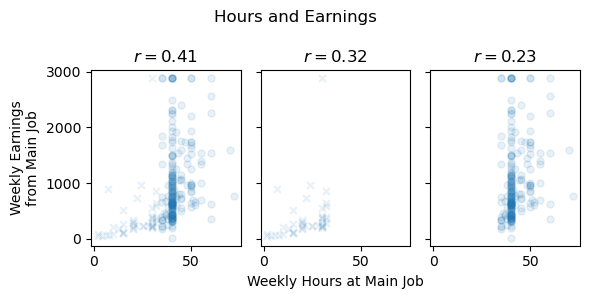

In [4]:
fig, axs = plt.subplots(1,3,
                       sharex = True,
                       sharey = True,
                       figsize = (6,3))

ax = axs[0]
#ax.scatter(hours_working, earnings, alpha = 0.1, color = 'C0')
ax.scatter(hours_working_pt, earnings_pt, alpha = 0.1, marker = 'x', s = 25) # color = (0,0.5,0.2))
ax.scatter(hours_working_ft, earnings_ft, alpha = 0.1, marker = 'o', s = 25, color = 'C0')

r = np.corrcoef(hours_working, earnings)[0][1]
ax.set_title(r"$r=$" + '{:.2f}'.format(r))
ax.set_ylabel("Weekly Earnings\nfrom Main Job")


ax = axs[1]
ax.scatter(hours_working_pt, earnings_pt, alpha = 0.1, marker = 'x', s = 25) # color = (0,0.5,0.2))
r = np.corrcoef(hours_working_pt, earnings_pt)[0][1]
ax.set_title(r"$r=$" + '{:.2f}'.format(r))
ax.set_xlabel("Weekly Hours at Main Job")


ax = axs[2]
ax.scatter(hours_working_ft, earnings_ft, alpha = 0.1, marker = 'o', s = 25, color = 'C0')
r = np.corrcoef(hours_working_ft, earnings_ft)[0][1]
ax.set_title(r"$r=$" + '{:.2f}'.format(r))

fig.suptitle("Hours and Earnings")

plt.tight_layout()
#plt.savefig("earnings_and_earnings_panel.pdf")